<a href="https://colab.research.google.com/github/ShinAsakawa/ShinAsakawa.github.io/blob/master/2023notebooks/2023_1124Knd_Ijn_Ask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%config InlineBackend.figure_format = 'retina'
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import IPython
isColab = 'google.colab' in str(IPython.get_ipython())

* date: 2023_1027
* author: 浅川伸一
* filename: 2023_1027Knd_Ijn_Ask.ipynb 名前変更，旧名は `2023_1027Knd_Ijn_Ask_s2p_p2s.ipynb` 理由は orthgraphy も追加したから。

# 符号化器‐復号化器 (encoder-decoder a.k.a seq2seq) モデルによる，単語認識過程 beyond triangle

`fit_seq2seq()`, `eval_seq2seq()` は，encoder 側が 系列データでも，埋め込みベクトルでも動作する。
従って，o2o, o2p, p2o, p2p, s2o, s2p の 6 モデルはこれでよいようだ。
残された，o2s, p2s, s2s を開発すれば良い。

<center>
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2006Kello_fig4.svg" style="width:39%">
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2006Kello_junction_fig5.svg" style="width:39%">
<!-- <img src="2006Kello_fig4.svg" width="39%"><img src="2006Kello_junction_fig5.svg" style="width:39%"> -->
<div style="background-color:lavender;text-align:left;width:66%">
左: RNN を用いた符号化器 (encoder) -復号化器 (decoder) モデル。
右: Kello らの結節点 (junction) モデル。中央の語彙ノード (lexical nodes) 上の数字 45263 は，交差点モデルが扱うことが可能な語彙数。<br/>
左: Kello+2006 Fig.4, 右: Kello+2006 Fig5
</div>
</center>


<center>
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2004Harm_Seidenberg_fig1_extended.svg" style="width:39%">
<!-- <img src="2004Harm_Seidenberg_fig1_extended.svg" width="39%"> -->
<div style="background-color:lavender;text-align:center;width:44%">
Harm\&Seidenberg2004 Fig. 1 を改変。
</div>
</center>

1. O(rthgraphy), P(honology), S(emnatics) のそれぞれに対して，ソースとターゲットと見立てた，9 つのデータセット，モデルを用意した。
モデル名を下表に示す。
表中の x2y は，ソースが x [o,p,s] でターゲットが y [o,p,s] であるモデルを意味する。
カッコ内は，ソースとターゲットのそれぞれが，系列データであれば Seq であり，埋め込みベクトルデータであれば Vec である。

|source\target   | O   | P   |  S |
|:--:|:--:|:---:|:--:|
| O | o2o (Seq2seq)| o2p (Seq2Seq)| o2s (Seq2Vec)|
| P | p2o (Seq2Seq)| p2p (Seq2Seq)| p2s (Seq2Vec)|
| S | s2o (Vec2Seq)| s2p (Vec2Seq)| s2s (Vec2Vec)|

ソースからターゲットへと系列データかベクトル埋め込みデータかによって，モデルは 4 種類に分類できる。

1. 系列から系列へ: 4 (o2o, o2p, p2o, p2p)，
2. 系列からベクトル埋め込みへ: 2 (o2s, p2s)
3. ベクトル埋め込みから系列へ: 2 (s2o, s2p)
4. ベクトル埋め込みからベクトル埋め込み 1

## メモ

1. 2023_1027 に近藤先生には，このコードのプロトタイプをお見せした。
すなわち GitHub にアップロード済である。
このファイルには，その後の改良が加えられている。
ただし，最初のセルで MeCab をソースコードからダウンロードして，コンパイル & インストールに時間を要したため，実施まではお見せしていない。

2. MeCab の使用は，未知語が入力として与えられた場合，仮のヨミを得るために使用している。
上記の役割を除けば MeCab は不要だと判断し，MeCab の使用を中止した


<center>
<!-- <img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2004Harm_Seidenberg_fig4c.svg"><br/>
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2004Harm_Seidenberg_fig4d.svg"><br/> -->
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2004Harm_Seidenberg_fig4ab.svg"><br/>
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2004Harm_Seidenberg_fig4c.svg">
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2004Harm_Seidenberg_fig4d.svg"><br/>
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/1999Levelt_blueprint.jpg" width=49%"><br/>
<!-- <img src="2004Harm_Seidenberg_fig4ab.svg"><br/>
<img src="2004Harm_Seidenberg_fig4c.svg">
<img src="2004Harm_Seidenberg_fig4d.svg"><br/> -->
`Harm & Seidenberg (2004)`, Figure 4 c, and d,
`Levelt 1999
</center>

<center>
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2015Loung_fig1.svg" width="24%"><br/>
ニューラル翻訳モデル。
青色がソース言語モデル，赤がターゲット言語モデルである。
ソース言語モデルの，最終時刻の中間層状態を，ターゲット言語モデルの開始時の中間層状態として用いる。
Loung+2015 Fig.1 より。    
</center>


* 文献
    * Harm & Seidenberg (2004) Computing the Meanings of Words in Reading: Cooperative Division of Labor Between Visual and Phonological Processes, Psychological Review, DOI:10.1037/0033-295X.111.3.662
    * Seq2seq 翻訳モデル: Sutskever+ (2014) Sequence to Sequence Learning with Neural Networks, [arXiv:1409.3215](https://arxiv.org/abs/1409.3215)
    * 注意つき符号化器‐復号化器モデル: Bahdanau, Cho, & Bengio (2015) NEURAL MACHINE TRANSLATION BY JOINTLY LEARNING TO ALIGN AND TRANSLATE, [arXiv:1409.0473](https://arxiv.org/abs/1409.0473)
    * もう一つの注意つき符号化器‐復号化器モデル Luong+ (2015) Effective Approaches to Attention-based Neural Machine Translation, [arXiv:1508.04025](https://arxiv.org/abs/1508.04025)


# 準備

## 共通のハイパーパラメータ宣言

In [3]:
# Definition of hyper parameters
config = {
    'batch_size': 1024,
    'adam_betas':(0.9, 0.98),
    'adam_eps':1e-9,
    'adam_lr':0.001,
    'n_hid': 128,
    'n_layers': 1,
    'bidirectional': False,
}
config

{'batch_size': 1024,
 'adam_betas': (0.9, 0.98),
 'adam_eps': 1e-09,
 'adam_lr': 0.001,
 'n_hid': 128,
 'n_layers': 1,
 'bidirectional': False}

## 必要なライブラリの輸入

In [ ]:
import sys
import os
import numpy as np
from tqdm.notebook import tqdm
import time
import datetime
import matplotlib.pyplot as plt

try:
    import jaconv
except ImportError:
    !pip install jaconv

try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib

if isColab:
    !pip install --upgrade termcolor==1.1
from termcolor import colored

try:
    import RAM
except ImportError:
    !git clone https://github.com/ShinAsakawa/RAM.git
    import RAM

# 近藤先生との議論から音韻情報の代替案として，ローマ字表記を採用することとした。
# このとき，訓令式の表記にすることとした。ヘボン式，パスポート式ではないことに注意
try:
    from kunrei import kunrei
except ImportError:
    !wget https://shinasakawa.github.io/2023notebooks/kunrei.py -O kunrei.py
    from kunrei import kunrei

## 意味表現として word2vec による意味埋め込みベクトルを使う

In [8]:
# word2vec のため gensim を使う
import requests
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import os
HOME = os.environ['HOME']

w2v_2017 = {
    'cbow200': 'http://www.cis.twcu.ac.jp/~asakawa/2017jpa/2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_cbow.bin.gz',
    'sgns200': 'http://www.cis.twcu.ac.jp/~asakawa/2017jpa/2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_sgns.bin.gz',
    'cbow300': 'http://www.cis.twcu.ac.jp/~asakawa/2017jpa/2017Jul_jawiki-wakati_neologd_hid300_win20_neg20_sgns.bin.gz',
    'sgns300': 'http://www.cis.twcu.ac.jp/~asakawa/2017jpa/2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_cbow.bin.gz'
}

w2v_2021 = {
    'cbow128': { 'id': '1B9HGhLZOja4Xku5c_d-kMhCXn1LBZgDb',
                'outfile': '2021_05jawiki_hid128_win10_neg10_cbow.bin.gz'},
    'sgns128': { 'id': '1OWmFOVRC6amCxsomcRwdA6ILAA5s4y4M',
                'outfile': '2021_05jawiki_hid128_win10_neg10_sgns.bin.gz'},
    'cbow200': { 'id': '1JTkU5SUBU2GkURCYeHkAWYs_Zlbqob0s',
                'outfile': '2021_05jawiki_hid200_win20_neg20_sgns.bin.gz'}
}

is2017=True

if isColab:
    from google_drive_downloader import GoogleDriveDownloader as gdd

    if is2017:
        response = requests.get(w2v_2017['cbow200'])
        fname = w2v_2017['cbow200'].split('/')[-1]
        with open(fname, 'wb') as f:
            f.write(response.content)
    else:
        #訓練済 word2vec ファイルの取得
        (f_id, outfile) = w2v_2021['sgns128']['id'], w2v_2021['sgns128']['outfile']
        gdd.download_file_from_google_drive(file_id=f_id,
                                            dest_path=outfile,
                                            unzip=False,
                                            showsize=True)

if is2017:
    w2v_base = os.path.join(HOME, 'study/2016wikipedia/') if not isColab else '.'
    w2v_file = '2017Jul_jawiki-wakati_neologd_hid200_win20_neg20_cbow.bin.gz'
    w2v_file = os.path.join(w2v_base, w2v_file)
else:
    w2v_base = os.path.join(HOME, 'study/2019attardi_wikiextractor.git/wiki_texts/AA') if isMac else '.'
    w2v_file = '2021_05jawiki_hid128_win10_neg10_sgns.bin'

w2v = KeyedVectors.load_word2vec_format(
    w2v_file,
    encoding='utf-8',
    unicode_errors='replace',
    binary=True)

## データセット Psylex71_Dataset の読み込み

In [ ]:
# データセットとしての Psylex71_Dataset の読み込み
from RAM import Psylex71_Dataset

psylex71_ds = Psylex71_Dataset(max_words=30000)
print(f'psylex71_ds の単語数:{psylex71_ds.__len__()}')

## データセットのヒストグラム描画

In [ ]:
from RAM import draw_word_char_histgram
draw_word_char_histgram(_dict=psylex71_ds.data_dict, key='phon', title='音韻', figsize2=(8,3))

## psylex71_ds に存在する全単語を word2vec の埋め込みベクトル行列にする

In [ ]:
# psylex71_ds データから word2vec の埋め込みベクトル行列を得る
_words = [dct['orth'] for dct in psylex71_ds.data_dict.values()]

# gensim() の `vectors_for_all()` 関数を持ちて，望む語彙で構成される word2vec 単語埋め込みモデルを作成
w2v_psylex71 = w2v.vectors_for_all(_words)

# NaN データが入っている可能性がるので変換
w2v_psylex71.vectors = np.nan_to_num(w2v_psylex71.vectors)
print(f'w2v_psylex71.vectors.shape:{w2v_psylex71.vectors.shape}')
words = w2v_psylex71.index_to_key
#len(words)

## psylex71 データセット中の単語における w2v の表示テスト

In [10]:
Wrd = input('単語を入力してください:')
color = 'blue'
while (Wrd != ""):
    if Wrd in w2v_psylex71:
        Idx = w2v_psylex71.key_to_index[Wrd]
        print(f'入力単語 Wrd:{colored(Wrd, color, attrs=["bold"])},',
              f'対応する単語番号 Idx:{colored(Idx, color, attrs=["bold"])},',
              f'w2v_psylex71.get_index({Wrd}):{colored(w2v_psylex71.get_index(Wrd), color, attrs=["bold"])}')
    else:
        print(colored(f'{Wrd} という単語はありません。','red', attrs=['bold']))
    Wrd = input('単語を入力してください (終了するには改行のみを入力):')

単語を入力してください:


## 書記素データの定義

In [ ]:
import RAM

def _grapheme(words=words):
    """必要と思われる書記素リストを返す"""

    num_alpha='０１２３４５６７８９ＡＢＣＤＥＦＧＨＩＪＫＬＭＮＯＰＱＲＳＴＵＶＷＸＹＺａｂｃｄｅｆｇｈｉｊｋｌｍｎｏｐｑｒｓｔｕｖｗｘｙｚ'
    hira = 'あいうえおかがきぎくぐけげこごさざしじすずせぜそぞただちぢつづてでとどなにぬねのはばぱひびぴふぶぷへべぺほぼぽまみむめもやゆよらりるれろわゐゑをんぁぃぅぇっゃゅょゎ'+'ゔ'
    kata = 'アイウエオカガキギクグケゲコゴサザシジスズセゼソゾタダチヂツヅテデトドナニヌネノハバパヒビピフブプヘベペホボポマミムメモヤユヨラリルレロワヰヱヲン'+'ヴヷヸヹヺァィゥヵヶェォッャョュヮ'
    symbols='、。，．・：；？！゛゜´｀¨＾‾＿ヽヾゝゞ〃仝々〆〇ー—‐／＼〜‖｜…‥‘’“”（）〔〕［］｛｝〈〉《》「」『』【】＋−±×÷＝≠＜＞≦≧∞∴♂♀°′″℃¥＄¢£％＃＆＊＠§☆★○●◎◇' + '◆□■△▲▽▼※〒→←↑↓〓∈∋⊆⊇⊂⊃∪∩∧∨¬⇒⇔∀∃∠⊥⌒∂∇≡≒≪≫√∽∝∵∫∬Å‰♯♭♪†‡¶◯'
    #greek='ΑΒΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩαβγδεζηθικλμνξοπρστυφχψω'
    #rosian='АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя'
    #digit_symbols='①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮⑯⑰⑱⑲⑳⑴⑵⑶⑷⑸⑹⑺⑻⑼⑽⑾⑿⒀⒁⒂⒃⒄⒅⒆⒇❶❷❸❹❺❻❼❽❾⒈⒉⒊⒋⒌⒍⒎⒏⒐'
    #alpha_symbols='ⅠⅡⅢⅣⅤⅥⅦⅧⅨⅩⅪⅫⅰⅱⅲⅳⅴⅵⅶⅷⅸⅹⅺⅻ⒜⒝⒞⒟⒠⒡⒢⒣⒤⒥⒦⒧⒨⒩⒪⒫⒬⒭⒮⒯⒰⒱⒲⒳⒴⒵'
    #units='㎜㎟㎝㎠㎤㎡㎥㎞㎢㎎㎏㏄㎖㎗ℓ㎘㎳㎲㎱㎰℉㏔㏋㎐㎅㎆㎇№㏍℡'
    #suits='♤♧♡♢♠♣♥♦〠☎〄☞☜☝☟⇆⇄⇅⇨⇦⇧⇩'
    #etc='①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮⑯⑰⑱⑲⑳ⅠⅡⅢⅣⅤⅥⅦⅧⅨⅩ㍉㌔㌢㍍㌘㌧㌃㌶㍑㍗㌍㌦㌣㌫㍊㌻㎜㎝㎞㎎㎏㏄㎡㍻〝〟№㏍℡㊤㊥㊦㊧㊨㈱㈲㈹㍾㍽㍼≒≡∫∮∑√⊥∠∟⊿∵∩∪㊙'
    #etc2='㍉㌢㍍㌔㌖㌅㌳㍎㌃㌶㌘㌕㌧㍑㍊㌹㍗㌍㍂㌣㌦㌻㌫㌀㌞㌪㌱㍇㍾㍽㍼㍻㍿∮∟⊿〝'

    # RAM で作成済の常用漢字リストを用いて単漢字リストを作成
    # 平成 22 年の改定により常用漢字は 2136 文字ある
    chars_list = [ch for ch in num_alpha+hira+kata+symbols]+ RAM.chars_joyo().char_list
    not_chars_list = []
    for wrd in tqdm(words):
        for ch in wrd:
            if (ch not in chars_list) and (ch not in not_chars_list):
                not_chars_list.append(ch)
    not_chars_list = sorted(not_chars_list)
    grapheme = chars_list + not_chars_list
    # 上記の処理により grapheme には 2768 文字である。
    # これに特殊トークン 4 つ ['<PAD>', '<SOW>', '<EOW>', '<UNK>'] を加えたリストを返す

    return ['<PAD>', '<SOW>', '<EOW>', '<UNK>'] + grapheme

grapheme = _grapheme()

## データセットの定義

In [12]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import gensim

def _collate_fn(batch):
    inps, tgts = list(zip(*batch))
    inps = list(inps)
    tgts = list(tgts)
    return inps, tgts


class psylex71_w2v_Dataset(Dataset):
    def __init__(self,
                 #direction='s2p',  # ['s2p', 'p2s']
                 source='seme',    # エンコーダ用 入力データ, ['orth', seme', 'phon'] のいずれか一つ
                 target='phon',    # デコーダ用 出力データ ,  ['orth', seme', 'phon'] のいずれか一つ
                 w2v:gensim.models.keyedvectors.KeyedVectors=w2v_psylex71,
                 old_ds:RAM.dataset.Psylex71_Dataset=psylex71_ds,
                 #mecab_yomi=yomi,
                 grapheme:list=grapheme,
                ):

        super().__init__()
        self.ds_name = 'psylex71_'+source+"2"+target
        self.source, self.target = source, target

        self.w2v = w2v
        self.old_ds = old_ds
        #self.mecab_yomi = yomi         # 未知の単語が入力された場合 MeCab を使って読みをえるため
        self.grapheme = grapheme

        self.words = w2v.index_to_key  # gensim の KeyedVectors を利用して単語リストとする
        self.W = w2v.vectors

        # 訓令式に従った日本語ローマ字表記 `kurei.py` 参照
        self.phoneme = ['<PAD>', '<SOW>', '<EOW>', '<UNK>', # 特殊トークン，純に，埋め草，語頭，語末，未知
                        'a', 'i', 'u', 'e', 'o',            # 母音
                        'a:', 'i:', 'u:', 'e:', 'o:',       # 長母音
                        'N', 'Q',                           # 撥音，拗音
                        'b', 'by', 'ch', 'd', 'dy', 'f', 'g', 'gy', 'h', 'hy', # 子音
                        'j', 'k', 'ky', 'm', 'my', 'n', 'ny',  'p', 'py', 'r', # 子音
                        'ry', 's', 'sy', 't', 'ty', 'w', 'y', 'z', 'zy']       # 子音



    def __getitem__(self, idx:int):
        wrd = self.words[idx]

        if self.source == 'phon':
            src = torch.LongTensor(self.wrd2phon_ids(wrd))
        elif self.source == 'seme':
            src = torch.tensor(self.w2v.get_vector(idx))
        elif self.source == 'orth':
            src = torch.LongTensor(self.wrd2orth_ids(wrd))
        else:
            src = None

        if self.target == 'phon':
            tgt = torch.LongTensor(self.wrd2phon_ids(wrd))
        elif self.target == 'seme':
            tgt = torch.tensor(self.w2v.get_vector(idx))
        elif self.target == 'orth':
            tgt = torch.LongTensor(self.wrd2orth_ids(wrd))
        else:
            tgt = None

        return src, tgt

    def __len__(self):
        return len(self.w2v)

    def getitem(self,
                idx:int):
        wrd = self.words[idx]
        _yomi = self.wrd2yomi(wrd)
        _yomi = kunrei(_yomi).split(' ')
        phon_ids = [self.phoneme.index(idx) for idx in _yomi]
        orth_ids = [self.grapheme.index(idx) for idx in wrd]
        return wrd, _yomi, phon_ids, orth_ids

    def source_ids2source(self, ids:list):

        if self.source == 'phon':
            return self.phon_ids2phn(ids)
        elif self.source == 'orth':
            return self.orth_ids2orth(ids)
        elif self.source == 'seme':
            wrd = self.getitem(ids)[0]
            return w2v.similar_by_word(wrd)
        else:
            return None


    def target_ids2target(self, ids:list):

        if self.target == 'phon':
            return self.phon_ids2phn(ids)
        elif self.target == 'orth':
            return self.orth_ids2orth(ids)
        elif self.target == 'seme':
            wrd = self.getitem(ids)[0]
            return w2v.similar_by_word(wrd)
        else:
            return None


    def wrd2orth_ids(self, wrd:str)->list:
        ids = [self.grapheme.index(ch) for ch in wrd]
        ids = [self.grapheme.index('<SOW>')] + ids + [self.grapheme.index('<EOW>')]
        #ids = [[self.grapheme.index('<SOW>')] + ids + [self.grapheme.index('<EOW>')]]
        return ids

    def wrd2phon_ids(self, wrd:str)->list:
        _yomi = self.wrd2yomi(wrd)
        _yomi = kunrei(_yomi).split(' ')
        ids = [self.phoneme.index(idx) for idx in _yomi]
        ids = [self.phoneme.index('<SOW>')] + ids + [self.phoneme.index('<EOW>')]
        return ids

    def get_wrdidx_from_word(self, wrd:str):
        if wrd in self.words:
            wrd_idx = self.w2v.get_index(wrd)
        else:
            wrd_idx = -1
        return wrd_idx

    def wrd2emb(self, wrd:str)->np.ndarray:
        if wrd in self.words:
            return self.w2v.get_vector(wrd)
        else:
            return None

    def wrd2wrd_ids(self, wrd:str)->int:
        if wrd in self.words:
            return self.words.index(wrd)
        else:
            return None

    def orth_ids2orth(self,
                      ids:np.ndarray)->str:
    #def orth_ids2orth(self, ids:list)->str:
        ret = [self.grapheme[idx] for idx in ids]
        return ret

    def wrd_idx2wrd(self, idx:int)->str:
        if 0 <= idx and idx < len(self.words):
            return self.words[idx]
        else:
            return None

    def wrd2onehot(self, wrd:str)->np.ndarray:
        ret = np.zeros((self.W.shape[0],), dtype=np.int32)
        if wrd in self.words:
            ret[self.w2v.get_index(wrd)] = 1
            return ret
        else:
            return None

    def phon_ids2phn(self, ids:np.ndarray):
        ret = "".join([self.phoneme[idx] for idx in ids])
        return ret

    def wrd2yomi(self, wrd:str)->list:
        if wrd in self.words:
            _yomi = self.old_ds.orth2info_dict[wrd]['ヨミ']
        else:
            _yomi = self.mecab_yomi(wrd).strip().split()[0]
        return _yomi

    def wrd2info(self, wrd:str)->dict:
        if wrd in self.words:
            return self.old_ds.orth2info_dict[wrd]
        else:
            return None


# 全部で 9 通りのデータセットを定義
psylex71_ds_o2o = psylex71_w2v_Dataset(source='orth', target='orth')
psylex71_ds_o2p = psylex71_w2v_Dataset(source='orth', target='phon')
psylex71_ds_o2s = psylex71_w2v_Dataset(source='orth', target='seme')

psylex71_ds_p2o = psylex71_w2v_Dataset(source='phon', target='orth')
psylex71_ds_p2p = psylex71_w2v_Dataset(source='phon', target='phon')
psylex71_ds_p2s = psylex71_w2v_Dataset(source='phon', target='seme')

psylex71_ds_s2o = psylex71_w2v_Dataset(source='seme', target='orth')
psylex71_ds_s2p = psylex71_w2v_Dataset(source='seme', target='phon')
psylex71_ds_s2s = psylex71_w2v_Dataset(source='seme', target='seme')

### 訓練データセットとテストデータへの分割。現時点で未使用

In [ ]:
# N_train = int(_psylex71_ds.__len__() * 0.9)
# N_test  = _psylex71_ds.__len__() - N_train
# train_dataset, val_dataset = torch.utils.data.random_split(dataset=_psylex71_ds, lengths=(N_train, N_test))

# モデルの定義

<div style="font-family:serif;font-size:14pt;color:purple;font-weight:900">

PyTorch RNN モデルの実装に対する注意メモ
    
* Encoder 側のデータと Decoder 側のデータそれぞれに対して Padding の処理を行う。
* Encoder 側のデータには Padding 値として `0` で埋める。
* Decoder 側のデータをモデルの forward で使う場合には、Padding 値は `0` を埋める。
* ただし，Decoder 側のデータを教師データとして使う場合には，Padding 値には -1 を用いて，埋めることに注意。
* `nn.Embedding()` のオプションに `padding_idx=O` を付け，`CrosEntropyLoss` のオプションに `ignore_index=-1` を付ける。

</div>


## 各モデルの宣言

In [ ]:
# 全モデル共通使用するライブラリの輸入
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

from RAM import Seq2Seq_wAtt
from RAM import Vec2Seq
from RAM import Seq2Vec
from RAM import Vec2Vec

from RAM import fit_seq2seq
from RAM import fit_seq2vec
from RAM import fit_seq2vec as fit_veq2seq
#from RAM import fit_vec2vec

from RAM import eval_seq2seq
from RAM import eval_seq2vec
#from RAM import eval_vec2seq
#from RAM import eval_vec2vec


n_layers = config['n_layers']
bidirectional = config['bidirectional']
n_hid = config['n_hid']

print(colored('# 1 写字モデル o2o', color='blue', attrs=["bold"]))
ds = psylex71_ds_o2o
o2o = Seq2Seq_wAtt(
    enc_vocab_size=len(ds.grapheme),
    dec_vocab_size=len(ds.grapheme),
    n_layers=n_layers, bidirectional=bidirectional, n_hid=n_hid).to(device)
print(o2o.eval())

print(colored('# 2 o2p 音読モデル意味関与なし', color='blue', attrs=["bold"]))
ds = psylex71_ds_o2p
o2p = Seq2Seq_wAtt(
    enc_vocab_size=len(ds.grapheme),
    dec_vocab_size=len(ds.phoneme),
    n_layers=n_layers, bidirectional=bidirectional, n_hid=n_hid).to(device)
print(o2p.eval())

print(colored('# 3 o2s 印字理解モデル', color='blue', attrs=["bold"]))
ds = psylex71_ds_o2s
o2s = Seq2Vec(
    enc_vocab_size=len(ds.grapheme),
    sem_dim=ds.w2v.vector_size,
    n_layers=n_layers, bidirectional=bidirectional, n_hid=n_hid).to(device)
print(o2s.eval())

print(colored('# 4 p2o 聞き書き ディクテーションモデル', color='blue', attrs=["bold"]))
ds = psylex71_ds_p2o
p2o = Seq2Seq_wAtt(
    enc_vocab_size=len(ds.phoneme),
    dec_vocab_size=len(ds.grapheme),
    n_layers=n_layers, bidirectional=bidirectional, n_hid=n_hid).to(device)
print(p2o.eval())

print(colored('# 5 p2p 復唱モデル', color='blue', attrs=["bold"]))
ds = psylex71_ds_p2p
p2p = Seq2Seq_wAtt(
    enc_vocab_size=len(ds.phoneme),
    dec_vocab_size=len(ds.phoneme),
    n_layers=n_layers, bidirectional=bidirectional, n_hid=n_hid).to(device)
print(p2p.eval())

print(colored('# 6 p2s 聴理解モデル', color='blue', attrs=["bold"]))
ds = psylex71_ds_p2s
p2s = Seq2Vec(
    enc_vocab_size=len(ds.phoneme),
    sem_dim=ds.w2v.vector_size,
    n_hid=n_hid, n_layers=n_layers, bidirectional=bidirectional).to(device)
print(p2s.eval())

print(colored('# 7 s2o 書字モデル', color='blue', attrs=["bold"]))
ds = psylex71_ds_s2o
s2o = Vec2Seq(
    sem_dim=ds.w2v.vector_size,
    dec_vocab_size=len(ds.grapheme),
    n_hid=n_hid, n_layers=n_layers, bidirectional=bidirectional).to(device)
print(s2o.eval())

print(colored('# 8 s2p 発話モデル', color='blue', attrs=["bold"]))
ds = psylex71_ds_s2p
s2p = Vec2Seq(
    sem_dim=ds.w2v.vector_size,
    dec_vocab_size=len(ds.phoneme),
    n_layers=n_layers, bidirectional=bidirectional, n_hid=n_hid).to(device)
print(s2p.eval())

print(colored('# 9 s2s 意味理解モデル', color='blue', attrs=["bold"]))
ds = psylex71_ds_s2s
s2s = Vec2Vec(
    sem_dim=ds.w2v.vector_size,
    n_hid=n_hid).to(device)
print(s2s.eval())

epoch: 1 batch:  671 loss:0.00039
epoch: 1 batch: 1342 loss:0.00014
epoch: 1 batch: 2013 loss:0.00010
epoch: 1 batch: 2684 loss:0.00003
epoch: 2 batch:  671 loss:0.00008
epoch: 2 batch: 1342 loss:0.00001
epoch: 2 batch: 2013 loss:0.00000
epoch: 2 batch: 2684 loss:0.00000
epoch: 3 batch:  671 loss:0.00000
epoch: 3 batch: 1342 loss:0.00000
epoch: 3 batch: 2013 loss:0.00000
epoch: 3 batch: 2684 loss:0.00000
epoch: 4 batch:  671 loss:0.00000
epoch: 4 batch: 1342 loss:0.00000
epoch: 4 batch: 2013 loss:0.00000
epoch: 4 batch: 2684 loss:0.00000
epoch: 5 batch:  671 loss:0.00000
epoch: 5 batch: 1342 loss:0.00000
epoch: 5 batch: 2013 loss:0.00000
epoch: 5 batch: 2684 loss:0.00000


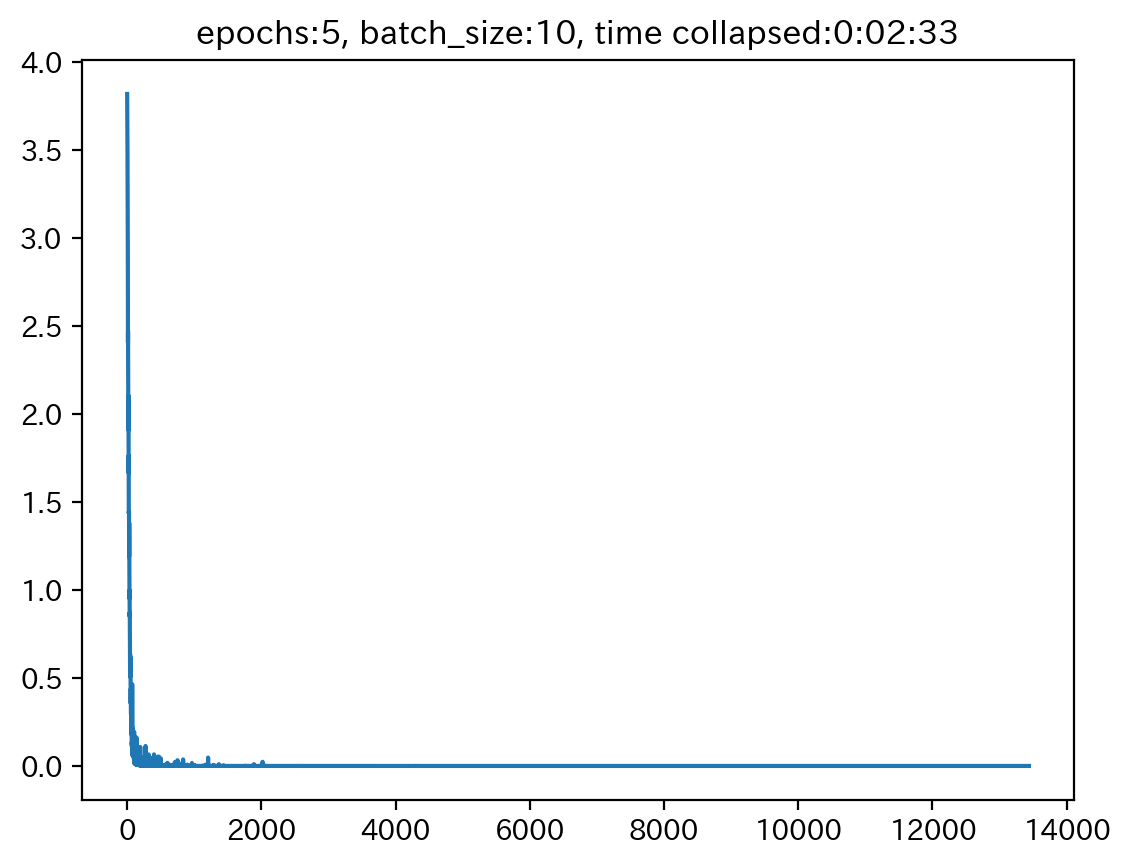

  0%|          | 0/26877 [00:00<?, ?it/s]

epoch: 1 batch:  671 loss:0.00027
epoch: 1 batch: 1342 loss:0.00011
epoch: 1 batch: 2013 loss:0.00003
epoch: 1 batch: 2684 loss:0.00002
epoch: 2 batch:  671 loss:0.00002
epoch: 2 batch: 1342 loss:0.00001
epoch: 2 batch: 2013 loss:0.00001
epoch: 2 batch: 2684 loss:0.00001
epoch: 3 batch:  671 loss:0.00000
epoch: 3 batch: 1342 loss:0.00000
epoch: 3 batch: 2013 loss:0.00000
epoch: 3 batch: 2684 loss:0.00000
epoch: 4 batch:  671 loss:0.00000
epoch: 4 batch: 1342 loss:0.00000
epoch: 4 batch: 2013 loss:0.00000
epoch: 4 batch: 2684 loss:0.00000
epoch: 5 batch:  671 loss:0.00000
epoch: 5 batch: 1342 loss:0.00000
epoch: 5 batch: 2013 loss:0.00000
epoch: 5 batch: 2684 loss:0.00000


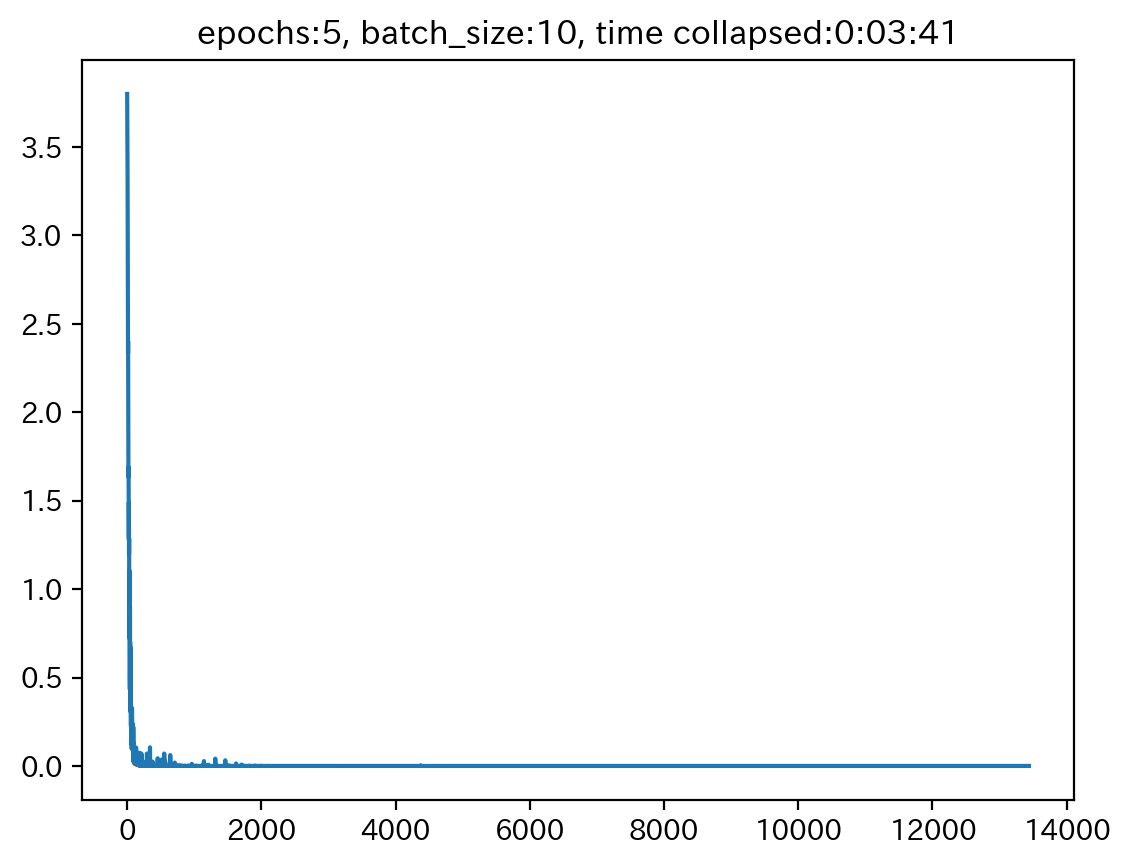

  0%|          | 0/26877 [00:00<?, ?it/s]

epoch: 1 batch:  671 loss:1.01286
epoch: 1 batch: 1342 loss:0.01191
epoch: 1 batch: 2013 loss:0.33986
epoch: 1 batch: 2684 loss:0.03791
epoch: 2 batch:  671 loss:0.00534


In [ ]:
%%time
# 読字モデル
errors_o2p = fit_seq2seq(epochs=5, model=o2p, ds=psylex71_ds_o2p, device=device)
result_o2p = eval_seq2seq(model=o2p, ds=psylex71_ds_o2p, device=device)

# 復唱モデル
errors_p2p = fit_seq2seq(epochs=5, model=p2p, ds=psylex71_ds_p2p, device=device)
result_p2p = eval_seq2seq(model=p2p, ds=psylex71_ds_p2p, device=device)

# 書き取りディクテーションモデル
errors_p2o = fit_seq2seq(epochs=10, model=p2o, ds=psylex71_ds_p2o, device=device)
result_p2o = eval_seq2seq(model=p2o, ds=psylex71_ds_p2o, device=device)

# 写字モデル
errors_o2o = fit_seq2seq(epochs=10, model=o2o, ds=psylex71_ds_o2o, device=device)
result_o2o = eval_seq2seq(model=o2o, ds=psylex71_ds_o2o, device=device)

In [ ]:
results = ['result_o2p', 'result_o2o', 'result_p2p', 'result_p2o']
#results = ['result_o2p', 'result_p2o']
for result in results:
    print(result, eval(result))

## o2p 結果をファイルに保存

In [ ]:
o2p.eval()
fname_saved = '2023_1117o2p_h128.pt'
torch.save(o2p.state_dict(), fname_saved)
state_dict = torch.load(fname_saved)

ds = psylex71_ds_o2p
_o2p = Seq2Seq_wAtt(
    enc_vocab_size=len(ds.grapheme),
    dec_vocab_size=len(ds.phoneme),
    n_layers=n_layers, bidirectional=bidirectional, n_hid=n_hid).to(device)
print(_o2p.eval())

_o2p.load_state_dict(state_dict)
_error_o2p = eval_seq2seq(model=_o2p, ds=psylex71_ds_o2p, device=device)
#print(errors['正解率'])
_error_o2p

In [ ]:
# o2s 黙読モデル
## モデルの訓練
errors_o2s = fit_seq2vec(epochs=1, model=o2s, ds=psylex71_ds_o2s, device=device)

## モデルの結果評価
result_o2s = eval_seq2vec(model=o2s, ds=psylex71_ds_o2s, isPrint=True, device=device)

In [ ]:
# p2s 聞き取りモデル
## モデルの訓練
errors_p2s = fit_seq2vec(epochs=1, model=p2s, ds=psylex71_ds_p2s, device=device)

## モデルの結果評価
eval_seq2vec(model=p2s, ds=psylex71_ds_p2s, isPrint=True, device=device)

In [ ]:
# s2o 書き出しモデル
## モデルの訓練
errors_s2o = fit_seq2seq(epochs=1, model=s2o, ds=psylex71_ds_s2o)
#errors_s2o = fit_seq2seq(epochs=15, model=s2o, ds=psylex71_ds_s2o)

## モデルの結果評価
result_s2o = eval_seq2seq(model=s2o, ds=psylex71_ds_s2o)

In [ ]:
# s2p 発話モデル
## モデルの訓練
errors_s2p = fit_seq2seq(epochs=15, model=s2p, ds=psylex71_ds_s2p)

## モデルの結果評価
result_s2p = eval_seq2seq(model=s2p, ds=psylex71_ds_s2p)

In [ ]:
# s2s 自発的納得モデル
start_time = time.time()   # 開始時刻の保存

dataloader = dl_s2s

model = s2s
# 最適化手法の定義
optimizer = optim.Adam(model.parameters(),lr=0.001)

# 損失関数の定義
criterion = nn.CrossEntropyLoss(ignore_index=-1)

# 訓練ループ
model.train()
interval = int(ds.__len__()/batch_size) >> 2
losses = []

dataloader = dl_s2s
epochs = 5
for epoch in range(epochs):
    i = 0
    for _inp, _tch in dataloader:

        enc_inp = pad_sequence(_inp, batch_first=True).to(device)
        dec_inp = pad_sequence(_tch, batch_first=True).to(device)
        tch = pad_sequence(_tch, batch_first=True, padding_value=-1.0).to(device)

        out = model(enc_inp, dec_inp)
        loss = criterion(out[0], tch[0])
        for h in range(1,len(tch)):
            loss += criterion(out[h], tch[h])
        losses.append(loss.item()/batch_size)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
        if (i % interval) == 0:
            print(f'epoch:{epoch:2d}, batch:{i:2d}, loss:{loss.item()/batch_size:.3f}')


end_time = time.time()
total_time = end_time - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f'Training time {total_time_str}')

plt.plot(losses)
plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
plt.show()

In [ ]:
errors_s2p = fit_seq2seq(epochs=15, model=s2p, ds=psylex71_ds_s2p)
result_s2p = eval_seq2seq(model=s2p, ds=psylex71_ds_s2p)

errors_s2o = fit_seq2seq(epochs=15, model=s2o, ds=psylex71_ds_s2o)
result_s2o = eval_seq2seq(model=s2o, ds=psylex71_ds_s2o)

# 書記+意味$\rightarrow$音韻 os2p モデル

## データセットの定義

### **<font style="color:teal">書記符号化器から書記埋め込みベクトルを取り出す</font>**

In [ ]:
orth_emb_vec = []
_o2p.eval()
ds = psylex71_ds_o2p
for N in range(ds.__len__()):
    inp, tch = ds.__getitem__(N)
    enc_emb = _o2p.encoder_emb(inp)
    enc_out, (hnx, cnx) = o2p.encoder(enc_emb)
    orth_emb_vec.append(hnx.detach().squeeze(0).numpy())
orth_emb = np.array(orth_emb_vec)
print(f'orth_emb.shape:{orth_emb.shape}')
print(f'len(grapheme):{len(grapheme)}')

In [ ]:
class OS2P_Dataset(Dataset):
    def __init__(self,
                 #phoneme:list=phoneme,
                 grapheme:list=grapheme,
                 orth_vecs:np.ndarray=orth_emb,
                 w2v:gensim.models.keyedvectors.KeyedVectors=w2v_psylex71,
                 seme_vecs:np.array=w2v_psylex71.vectors,
                 old_ds:RAM.dataset.Psylex71_Dataset=psylex71_ds,
                )->None:
        self.ds_name = 'orth_seme_2_phon_dataset'
        self.w2v = w2v

        self.phoneme = ['<PAD>', '<SOW>', '<EOW>', '<UNK>', # 特殊トークン，純に，埋め草，語頭，語末，未知
                        'a', 'i', 'u', 'e', 'o',            # 母音
                        'a:', 'i:', 'u:', 'e:', 'o:',       # 長母音
                        'N', 'Q',                           # 撥音，拗音
                        'b', 'by', 'ch', 'd', 'dy', 'f', 'g', 'gy', 'h', 'hy', # 子音
                        'j', 'k', 'ky', 'm', 'my', 'n', 'ny',  'p', 'py', 'r', # 子音
                        'ry', 's', 'sy', 't', 'ty', 'w', 'y', 'z', 'zy']       # 子音

        self.orth_vecs = orth_vecs
        self.seme_vecs = seme_vecs
        self.words = w2v.index_to_key
        self.old_ds = old_ds
        wrd2phn = {}
        for wrd in self.words:
            yomi = self.wrd2yomi(wrd)
            phon = kunrei(yomi).split(' ')
            wrd2phn[wrd] = phon
        self.wrd2phn = wrd2phn

    def __len__(self):
        return len(self.words) # 936

    def __getitem__(self, idx:int)->list:
        orth_vec = torch.tensor(self.orth_vecs[idx]).to(device)
        seme_vec = torch.tensor(self.seme_vecs[idx]).to(device)
        inp = torch.cat((orth_vec, seme_vec)).to(device)

        wrd = self.words[idx]
        phn_ids = self.wrd2phon_ids(wrd)
        tch = phn_ids
        # phon_ids = self.wrd2phn[wrd]
        # tch = [self.phoneme.index('<SOW>')]+phon_ids+[self.phoneme.index('<EOW>')]
        # print(f'wrd:{wrd}, tch:{tch}, type(tch):{type(tch)}')
        # sys.exit()
        tch = torch.LongTensor(tch).to(device)
        return inp, tch

    def getitem(self, idx:int):
        wrd = self.words[idx]
        phon = self.wrd2phn[wrd]
        phon_ids = [self.phoneme.index(p) for p in phon]
        phon_ids = [self.phoneme.index('<SOW>')]+phon_ids+[self.phoneme.index('<EOW>')]
        return wrd, phon, phon_ids

    def phon_ids2phon(self, ids:list)->list:
        return [self.phoneme[idx] for idx in ids]

    def target_ids2target(self, ids:list):
        return self.phon_ids2phon(ids)

    def phon_ids2phon(self, ids:list)->list:
        return [self.phoneme[idx] for idx in ids]

    def wrd2yomi(self, wrd:str)->list:
        if wrd in self.words:
            _yomi = self.old_ds.orth2info_dict[wrd]['ヨミ']
        # else:
        #     _yomi = self.mecab_yomi(wrd).strip().split()[0]
        return _yomi

    def wrd2phon_ids(self, wrd:str)->list:
        _yomi = self.wrd2yomi(wrd)
        _yomi = kunrei(_yomi).split(' ')
        ids = [self.phoneme.index(idx) for idx in _yomi]
        ids = [self.phoneme.index('<SOW>')] + ids + [self.phoneme.index('<EOW>')]
        return ids

    def wrd2info(self, wrd:str)->dict:
        if wrd in self.words:
            return self.old_ds.orth2info_dict[wrd]
        else:
            return None


os2p_ds = OS2P_Dataset()
#print(os2p_ds.__len__())
Ns = np.random.permutation(os2p_ds.__len__())
for N in Ns[:3]:
    inp, tch = os2p_ds.__getitem__(N)
    print(f'inp.size():{inp.size()}')
    print(f'n_hid:{n_hid}')
    print(f'tch:{tch}')
    print(f'os2p_ds.phon_ids2phon(tch.detach().numpy()):{os2p_ds.phon_ids2phon(tch.detach().numpy())}')
    print(f'os2p_ds.words[0]:{os2p_ds.words[N]}')

In [ ]:
import copy

class Vec2Seq(nn.Module):
    def __init__(self,
                 inp_dim:int,
                 dec_vocab_size:int,
                 n_hid:int,
                 n_layers:int=2,
                 decoder:nn.Module=o2p.decoder,
                 bidirectional:bool=False):
        super().__init__()

        self.decoder = copy.deepcopy(decoder)

        # 単語の意味ベクトル a.k.a 埋め込み表現 を decoder の中間層に接続するための変換層
        # 別解としては，入力層に接続する方法があるが，それはまた別実装にする
        self.enc_transform_layer = nn.Linear(
            in_features=inp_dim,
            out_features=n_hid)
        self.decoder_emb = nn.Embedding(
            num_embeddings=dec_vocab_size,
            embedding_dim=n_hid,
            padding_idx=0)

        self.decoder = nn.LSTM(
            input_size=n_hid,
            hidden_size=n_hid,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=bidirectional)

        # 最終出力層
        self.bi_fact = 2 if bidirectional else 1
        self.out_layer = nn.Linear(self.bi_fact * n_hid, dec_vocab_size)

    def forward(self, enc_inp, dec_inp):
        enc_emb = self.enc_transform_layer(enc_inp)
        hnx, cnx = enc_emb.clone(), enc_emb.clone()
        hnx = hnx.unsqueeze(0)
        cnx = cnx.unsqueeze(0)

        if self.bi_fact == 2:
            hnx = hnx.repeat(2)
            cnx = cnx.repeat(2)

        dec_emb = self.decoder_emb(dec_inp)

        batch_size = enc_inp.size(0)
        exp_hid_size = self.decoder.get_expected_hidden_size(enc_inp, batch_sizes=[batch_size])
        dec_out, (hny, cny) = self.decoder(dec_emb,(hnx, cnx))

        return self.out_layer(dec_out)

# 以下確認作業
ds = os2p_ds
os2p = Vec2Seq(
    inp_dim=ds.w2v.vector_size+n_hid,
    dec_vocab_size=len(ds.phoneme),
    n_hid=n_hid,
    n_layers=n_layers,
    bidirectional=bidirectional).to(device)
print(os2p.eval())

res = fit_seq2seq(epochs=1, model=os2p, ds=os2p_ds, interval=8)

## モデルの訓練

In [ ]:
res = fit_seq2seq(epochs=10, model=os2p, ds=os2p_ds, interval=8)

## 訓練結果の評価

In [ ]:
os2p_errors = eval_seq2seq(model=os2p, ds=os2p_ds)

In [ ]:
os2p_errors.keys()
for err in os2p_errors['エラー']:
    print(err)
print(f"正解率: {os2p_errors['正解率']:.3f} %")


In [ ]:
print(os2p.eval())
state_dict = os2p.state_dict()
fname = '2023_1117os2ps_hid128.pt'
torch.save(state_dict, fname)

os2p_saved = Vec2Seq(
    inp_dim=ds.w2v.vector_size+n_hid,
    dec_vocab_size=len(ds.phoneme),
    n_hid=n_hid,
    n_layers=n_layers,
    bidirectional=bidirectional).to(device)
os2p_saved.load_state_dict(state_dict)
os2p_saved_errors = eval_seq2seq(model=os2p_saved, ds=os2p_ds)
#os2p_saved_errors.keys()
for err in os2p_saved_errors['エラー']:
    print(err)
print(f"正解率: {os2p_saved_errors['正解率']:.3f} %")
